In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')


/Volumes/Samsung SSD 990 EVO Plus/Documents/MI01/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


# Sentiment Analysis on Kaggle sentiment analysis dataset
sentiment analysis tasks on kaggle sentiment analysis dataset using simple machine learning model: Naive bayes


## Including needed libraries

In [2]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel

## Uploading Data

In [3]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

True
True


In [4]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')


In [5]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Data Preprocessing

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [7]:
test_df.info() # no selected_text

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


#### Handling null values

In [8]:
train_df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [9]:
train_df = train_df.dropna() # generate new dataframe, droping NAs
train_df.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [10]:
test_df.isnull().sum()

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64

In [11]:
test_df = test_df.dropna()
test_df.isnull().sum()

textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

#### Removing stopwords & lowercase all text

In [12]:
# Download necessary NLTK data
nltk.download('stopwords') # Common stopwards are the, a, an, is, are, was, were, in, on, at, of, for, and, or, which doesn't change the meanings of the sentences.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linnan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    """
    input_text = "The cat is sitting on the mat and it is very cute"
    <-->
    cat, sitting, mat, very, cute
    """
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text



In [14]:
# Apply preprocessing on train dataset，build colomn
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,"i`d responded, going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me...
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,"sons ****, couldn`t put releases already bought"


In [15]:
# Apply preprocessing on test dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting (precisely -- sk...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,"recession hit veronique branquinho, quit compa..."
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,http://twitpic.com/4w75p - like it!!


## Check Imbalancing

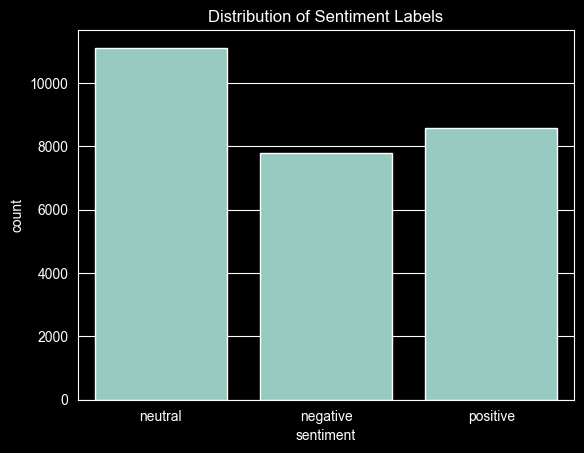

In [16]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [17]:
# 1. Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)

# 2. Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.25, random_state=42)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

In [18]:
print(len(trainval_x),len(val_x),len(test_x))

27480 6870 3534


In [19]:
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class TextDataset(Dataset):
    """
    Text -> Bert recognizable format
    """
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer # BERT 分词器
        self.max_length = max_length

    def __len__(self):
        """
        返回数据集总样本数
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Partition by index
        """
        # Tokenize and encode the text
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),    # Squeeze dim: [1, 128] -> [128]
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Extract embeddings for all data
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.
    Using a pretrained BERT model to extract semantic embeddings from text, each text sample is converted into a fixed-length 768-dimensional embedding vector.

    Because BERT requires all input token sequences to have the same length, a tokenizer is first used to “standardize” sentences of arbitrary length into a fixed length: sequences that are too long are truncated, and those that are too short are padded.
    
    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation，BERT 中[CLS] token represent the semantic vof the entire sentence

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix，shaoe: #samples × 768
    return torch.cat(embeddings, dim=0)

# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(train_x, train_y, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(val_x, val_y, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings =train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings =val_embeddings.cpu()


In [20]:
print(train_embeddings.size())
print(val_embeddings.size())

torch.Size([20610, 768])
torch.Size([6870, 768])


In [21]:
criterion= nn.CrossEntropyLoss()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings.squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):

        # Pass through the fully connected layer
        logits = self.fc(input_ids)
        return logits

# training script

def train( model, train_loader, optimizer, epoch, log_interval=50):
    model.train()
    loss_cpu = 0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        # inputs, target = inputs.cuda(), target.cuda()
        inputs, target = inputs.to(device), target.to(device)
        inputs =inputs.detach()

        # ====================
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, target)
        # ====================

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            # print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
            #     %(epoch, EPOCHS, batch_idx+1,
            #         (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            # #n_iter=epoch * len(train_loader) + batch_idx
            
            # ====================
            current_acc = 100. * correct / total
            total_batches = len(train_loader)
            print(
                '| Epoch [%3d/%3d] Iter [%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%% LR: %.6f'
                % (epoch, EPOCHS, batch_idx+1, total_batches, 
                   loss.item(), current_acc, get_lr(optimizer))
            )
            # ====================

    # ====================
    avg_loss = loss_cpu / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f'| Epoch {epoch} Train Finished | Avg Loss: {avg_loss:.4f} | Total Acc: {epoch_acc:.3f}%')
    # ====================
    
    return avg_loss

# testing script
def test( model, test_loader,epoch):
    model.eval()
    correct = 0
    total = 0
    test_loss_MSE =0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            # inputs, target = inputs.cuda(), target.cuda()
            inputs, target = inputs.to(device), target.to(device)
            outputs  = model(inputs)
            loss = criterion(outputs,target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss_MSE+= loss.item()

    test_loss_MSE = test_loss_MSE/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss_MSE, 100.*correct/total

In [22]:
print ("Let us Train.")
EPOCHS = 50
model = SentimentClassifier(768, NUM_CLASSES).to(device)
model_test = SentimentClassifier(768, NUM_CLASSES).to(device)
best_error = float('inf')
LEARNING_RATE = 1e-3
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

traindataset = EmbeddingDataset(train_embeddings, train_y)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, val_y)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=True)



optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7)

train_history = []
val_history = []
print('----------------------------------------------------------------------------------------------------')
print('3/ training model 1')
print('----------------------------------------------------------------------------------------------------')

iter =0
for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)
    #lr_scheduler.step()
    
    # ====================
    val_loss, val_acc = test(model, valloader,epoch)
    # ====================
    
    val_history.append(val_loss)
    lr_scheduler.step(val_loss)
    print('lr =',get_lr(optimizer))

    if val_loss <best_error:
        best_error=val_loss
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)

print ("Training Done!")

Let us Train.
----------------------------------------------------------------------------------------------------
3/ training model 1
----------------------------------------------------------------------------------------------------
| Epoch [  0/ 50] Iter [  1/323]		Loss: 1.1625 Acc@1: 45.312% LR: 0.001000
| Epoch [  0/ 50] Iter [ 51/323]		Loss: 1.0724 Acc@1: 40.962% LR: 0.001000
| Epoch [  0/ 50] Iter [101/323]		Loss: 1.0393 Acc@1: 41.058% LR: 0.001000
| Epoch [  0/ 50] Iter [151/323]		Loss: 1.0800 Acc@1: 42.208% LR: 0.001000
| Epoch [  0/ 50] Iter [201/323]		Loss: 1.0720 Acc@1: 43.361% LR: 0.001000
| Epoch [  0/ 50] Iter [251/323]		Loss: 1.0456 Acc@1: 43.955% LR: 0.001000
| Epoch [  0/ 50] Iter [301/323]		Loss: 1.0291 Acc@1: 44.778% LR: 0.001000
| Epoch 0 Train Finished | Avg Loss: 1.0440 | Total Acc: 45.240%

| Validation Epoch #0			Loss: 1.0119 Acc@1: 53.22%
lr = 0.001
Best RMSE is of : 0.9883466556116387 for epoch : 0 ERROR TEST =  0.9883466556116387
| Epoch [  1/ 50] Iter [  1

## Evaluation

In [23]:
testdataset = TextDataset(test_x,test_y, tokenizer, MAX_LENGTH)
testloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader, device)
test_embeddings =test_embeddings.cpu()

In [24]:
print('==================== ')
print('Test set = ')
testdataset = EmbeddingDataset(test_embeddings, test_y)
testdataset = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True)
test_loss,accu = test(model, testdataset,epoch)
print('==================== ')

Test set = 

| Validation Epoch #49			Loss: 1.1777 Acc@1: 63.92%


## Questions

**q0/  please analyse the dataset with differents classical machine learning model**

**q1/  please perform a classification with differents classical machine learning model and analyse the performences**

**q2/  please perform a classification with a MLP?**

**q3/  please analyse all the performences and explain which is the best**

**q4/  please use an LLM compare your performences to a LLM**

**q5/  please explain why I choose a BERT embedding instead of the raw text**

**q6/  please read the BERT paper and explain the BERT architecture**

**q7/  please finetue with LORA an LLM to classify the sentiment (optional)**

## Q0: Analyse the dataset with different classical machine learning models

Q0: DATASET ANALYSIS

Dataset Shape:
	Training set: 20610 samples
	Validation set: 6870 samples
	Test set: 3534 samples

Class Distribution in Training Set:
	Negative (0): 5825 samples (28.26%)
	Neutral (1): 8330 samples (40.42%)
	Positive (2): 6455 samples (31.32%)

3. Text Length Statistics (after preprocessing):


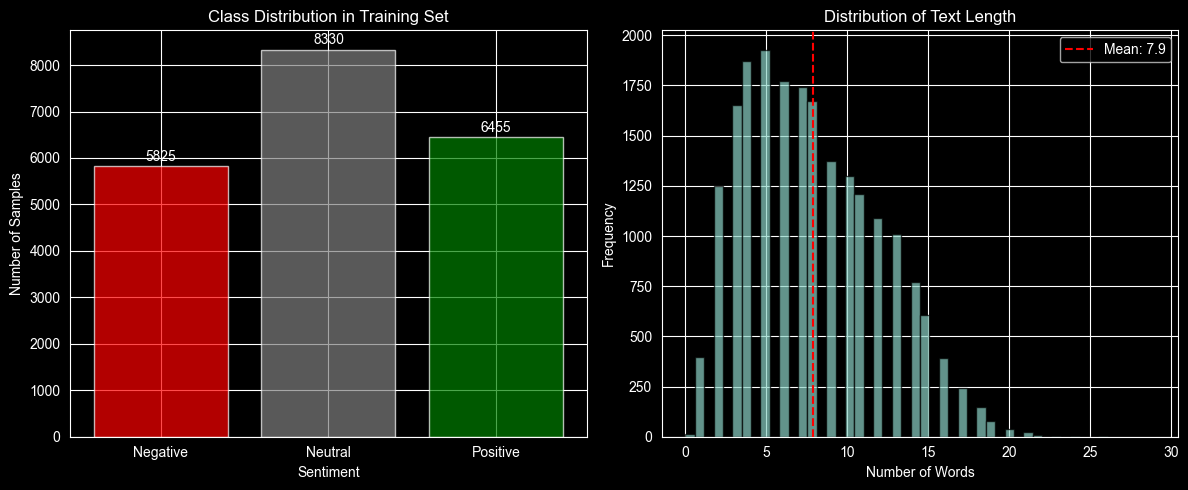

In [25]:
# Q0: Dataset Analysis
print("="*80)
print("Q0: DATASET ANALYSIS")
print("="*80)

# Basic statistics
print("\nDataset Shape:")
print(f"\tTraining set: {len(train_x)} samples")
print(f"\tValidation set: {len(val_x)} samples")
print(f"\tTest set: {len(test_x)} samples")

# Class distribution
print("\nClass Distribution in Training Set:")
from collections import Counter
train_class_dist = Counter(train_y)
for class_label, count in sorted(train_class_dist.items()):
    sentiment_name = {0: "Negative", 1: "Neutral", 2: "Positive"}[class_label]
    print(f"\t{sentiment_name} ({class_label}): {count} samples ({count/len(train_y)*100:.2f}%)")

# Text length statistics
print("\n3. Text Length Statistics (after preprocessing):")
train_lengths = [len(text.split()) for text in train_x]

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
classes = ['Negative', 'Neutral', 'Positive']
counts = [train_class_dist[0], train_class_dist[1], train_class_dist[2]]
plt.bar(classes, counts, color=['red', 'gray', 'green'], alpha=0.7)
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Samples')
plt.xlabel('Sentiment')
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(np.mean(train_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(train_lengths):.1f}')
plt.legend()

plt.tight_layout()
plt.show()


## Rapport de la question Q0 - Analyse du jeu de données

### Approche de l'équipe

La question Q0 demande une analyse multidimensionnelle du jeu de données, incluant principalement :

1.  **Statistiques sur la taille des données** - Connaître le nombre d'échantillons.
   
2.  **Analyse de la distribution des classes** - Vérifier s'il existe un déséquilibre entre les classes.
   
3.  **Analyse de la longueur du texte** - Comprendre les caractéristiques du texte.
   
4.  **Visualisation** - Présenter visuellement les caractéristiques des données.

---

### Analyse

#### 1. Répartition des sentiments dans l'ensemble d'entraînement

Ce graphique montre la quantité de textes dans chaque catégorie de sentiment.

Les catégories ne sont pas parfaitement équilibrées, mais la différence reste modérée. Pendant l’entraînement du modèle, il faut veiller à ne pas privilégier trop la catégorie neutres (car elle contient plus de données). On peut utiliser un paramètre de « poids par catégorie » pour corriger ce point.

---

#### 2. Distribution de la longueur des textes

Ce graphique indique combien de mots contient chaque texte :

- La longueur moyenne est de 7,9 mots : les textes sont donc courts.
  
- La plupart des textes ont entre 5 et 15 mots ; très peu ont plus de 20 mots.

Ces textes courts sont faciles à traiter avec BERT. On peut configurer le modèle pour accepter des textes de maximum 20 à 30 mots : cela suffit pour presque tous les cas et accélère l’entraînement.

---

#### 3. Synthèse

Le jeu de données présente une légère inégalité entre les catégories, mais cela ne pose pas de problème majeur. La courte longueur des textes est un avantage pour BERT, car son attention bidirectionnelle comprend bien les petits textes avec peu de mots.

## Q1: Classification with Different Classical Machine Learning Models

Q1: CLASSICAL MACHINE LEARNING MODELS

1. Defining machine learning models...
   Number of models: 5

2. Training and Evaluating Models:

Model: Naive Bayes

Training Time: 0.03 seconds
Validation Accuracy: 37.26%
Test Accuracy: 36.59%

Classification Report (Test Set):
              precision    recall  f1-score   support

    Negative     0.3801    0.0839    0.1375      1001
     Neutral     0.4640    0.2252    0.3032      1430
    Positive     0.3387    0.8042    0.4766      1103

    accuracy                         0.3659      3534
   macro avg     0.3942    0.3711    0.3058      3534
weighted avg     0.4011    0.3659    0.3104      3534

Model: Logistic Regression


/Volumes/Samsung SSD 990 EVO Plus/Documents/MI01/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training Time: 4.62 seconds
Validation Accuracy: 64.29%
Test Accuracy: 64.80%

Classification Report (Test Set):
              precision    recall  f1-score   support

    Negative     0.6555    0.6084    0.6311      1001
     Neutral     0.6067    0.6601    0.6323      1430
    Positive     0.7026    0.6682    0.6849      1103

    accuracy                         0.6480      3534
   macro avg     0.6549    0.6456    0.6494      3534
weighted avg     0.6505    0.6480    0.6484      3534

Model: Linear SVM

Training Time: 33.56 seconds
Validation Accuracy: 64.29%
Test Accuracy: 64.91%

Classification Report (Test Set):
              precision    recall  f1-score   support

    Negative     0.6383    0.6134    0.6256      1001
     Neutral     0.6203    0.6510    0.6353      1430
    Positive     0.6993    0.6791    0.6891      1103

    accuracy                         0.6491      3534
   macro avg     0.6526    0.6478    0.6500      3534
weighted avg     0.6500    0.6491    0.6493   

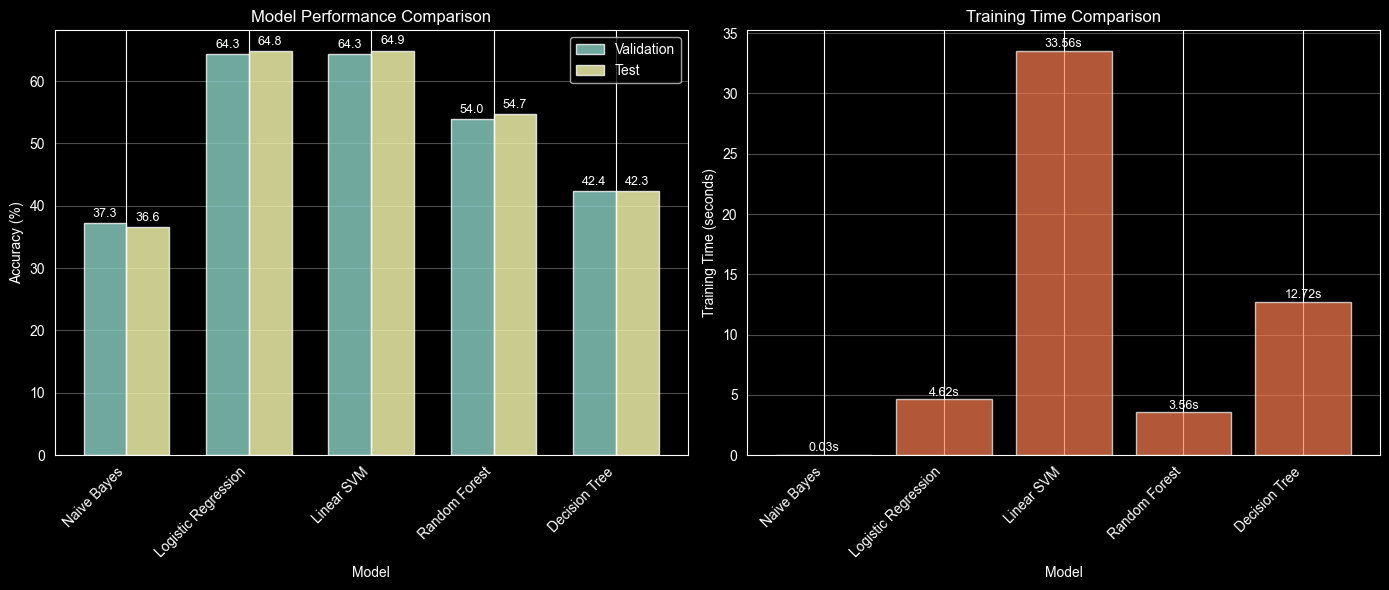


Best Classical Model: Linear SVM
Test Accuracy: 64.91%


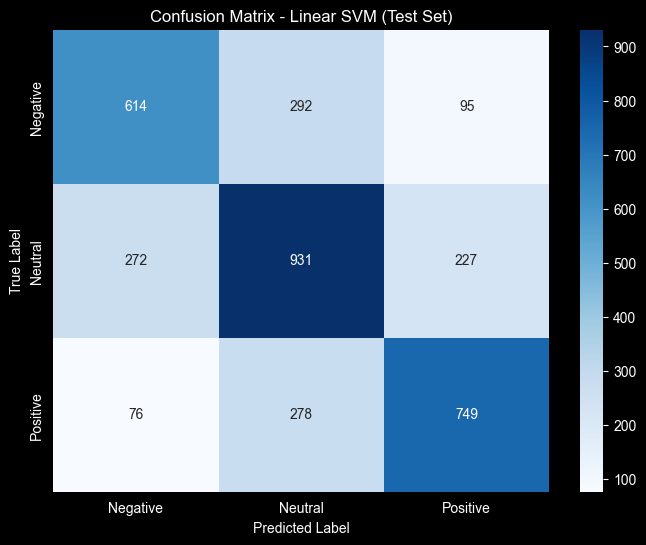

In [26]:
# Q1: Classical Machine Learning Models
print("="*80)
print("Q1: CLASSICAL MACHINE LEARNING MODELS")
print("="*80)

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time

# Use BERT embeddings
print("\n1. Defining machine learning models...")
# Define models
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear SVM": LinearSVC(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42)
}
print(f"   Number of models: {len(models)}")

# Store results
results_classical = {}

# Train and evaluate each model
print("\n2. Training and Evaluating Models:\n")
for model_name, model in models.items():
    print(f"{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")

    # Training
    start_time = time.time()
    model.fit(train_embeddings, train_y)
    train_time = time.time() - start_time

    # Validation predictions
    val_pred = model.predict(val_embeddings)
    val_accuracy = accuracy_score(val_y, val_pred)

    # Test predictions
    test_pred = model.predict(test_embeddings)
    test_accuracy = accuracy_score(test_y, test_pred)

    print(f"\nTraining Time: {train_time:.2f} seconds")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    # Classification report on test set
    print(f"\nClassification Report (Test Set):")
    print(classification_report(test_y, test_pred,
                                target_names=['Negative', 'Neutral', 'Positive'],
                                digits=4))

    # Store results
    results_classical[model_name] = {
        'model': model,
        'train_time': train_time,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'val_pred': val_pred,
        'test_pred': test_pred
    }

# Visualize results
print("\n3. Performance Comparison:\n")
model_names = list(results_classical.keys())
val_accuracies = [results_classical[name]['val_accuracy']*100 for name in model_names]
test_accuracies = [results_classical[name]['test_accuracy']*100 for name in model_names]

plt.figure(figsize=(14, 6))

# Accuracy comparison
plt.subplot(1, 2, 1)
x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8)
plt.bar(x + width/2, test_accuracies, width, label='Test', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
for i, (v, t) in enumerate(zip(val_accuracies, test_accuracies)):
    plt.text(i - width/2, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, t + 0.5, f'{t:.1f}', ha='center', va='bottom', fontsize=9)

# Training time comparison
plt.subplot(1, 2, 2)
train_times = [results_classical[name]['train_time'] for name in model_names]
plt.bar(model_names, train_times, color='coral', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(train_times):
    plt.text(i, v + 0.05, f'{v:.2f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Confusion matrix for best model
best_model_name = max(results_classical.keys(), key=lambda k: results_classical[k]['test_accuracy'])
print(f"\nBest Classical Model: {best_model_name}")
print(f"Test Accuracy: {results_classical[best_model_name]['test_accuracy']*100:.2f}%")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_y, results_classical[best_model_name]['test_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Rapport de la question Q1 : Classification avec différents modèles d'apprentissage automatique traditionnels

### Approche de l'équipe

La question Q1 nécessite l'utilisation de plusieurs modèles d'apprentissage automatique (Machine Learning) traditionnels pour la classification des sentiments, ainsi qu'une analyse comparative de leurs performances. Les étapes principales comprennent :

1.  **Définition des modèles** - Définir plusieurs algorithmes de classification classiques.
   
2.  **Entraînement et évaluation** - Entraîner les modèles et calculer les indicateurs d'évaluation.
   
3.  **Comparaison des performances** - Comparer visuellement les résultats.

---

### Implémentation du code et analyse

#### 1. Définition des modèles

On analyse des caractéristiques des modèles :

| Modèle | Principe | Avantages | Inconvénients |
|------|------|------|------|
| **Naive Bayes** | Basé sur le théorème de Bayes, suppose l'indépendance des caractéristiques | Entraînement rapide, adapté à la classification de texte | L'hypothèse d'indépendance est trop idéaliste |
| **Logistic Regression** | Modèle linéaire + fonction Sigmoid | Forte interprétabilité, résultats stables | Difficile de capturer les relations non linéaires |
| **Linear SVM** | Cherche l'hyperplan à marge maximale | Excellente performance dans les espaces de haute dimension | Lent à entraîner sur de grands jeux de données |
| **Random Forest** | Vote d'ensemble de plusieurs arbres de décision | Anti-surajustement, gère bien le bruit | Modèle lourd, inférence plus lente |
| **Decision Tree** | Division récursive basée sur les caractéristiques | Très forte interprétabilité | Sujet au surajustement (overfitting) |

**Analyse des hyperparamètres** :

- `alpha` : Coefficient de lissage de Laplace pour Naive Bayes, pour éviter les problèmes de probabilité nulle.

- `max_iter` : Nombre maximum d'itérations pour assurer la convergence du modèle.

- `n_estimators` : Nombre d'arbres de décision dans la Forêt Aléatoire.

- `max_depth` : Limite la profondeur de l'arbre pour éviter le surajustement.

- `n_jobs` : Utilise tous les cœurs du CPU pour un entraînement parallèle.

---

#### 2. Boucle d'entraînement et d'évaluation

```python
for model_name, model in models.items():
    on évalue
```

**Explication des indicateurs d'évaluation** :

- **Accuracy (Précision globale)** : Nombre de prédictions correctes / Nombre total d'échantillons.

- **Precision (Précision)** : Proportion d'échantillons réellement positifs parmi ceux prédits comme positifs.

- **Recall (Rappel)** : Proportion d'échantillons correctement prédits parmi ceux qui sont réellement positifs.

- **F1-Score** : Moyenne harmonique de la Précision et du Rappel.

---

#### 3. Comparaison visuelle des performances

##### 3.1 Performances des modèles
Le graphique de comparaison des performances montre le taux de précision de chaque modèle sur les ensembles de validation et de test.

Deux modèles se distinguent par leurs résultats les plus élevés : Logistic Regression et Linear SVM, avec une précision d’environ 64 à 65 % sur les deux ensembles. On note aussi que leur précision sur l’ensemble de test est légèrement supérieure à celle de la validation, ce qui indique que ces modèles se généralisent bien et ne souffrent pas de surapprentissage.

Le modèle Random Forest obtient une performance moyenne, avec une précision d’environ 55 %. Enfin, les modèles Naive Bayes et Decision Tree affichent les pires résultats, avec une précision comprise entre 36 % et 43 %.

##### 3.2 Temps d’entraînement

Le graphique de comparaison des temps d’entraînement indique combien de temps chaque modèle met à s’entraîner. Le modèle le plus rapide est Naive Bayes, qui ne nécessite que 0,09 seconde pour s’entraîner. À l’inverse, Linear SVM est le plus lent (41,78 secondes) : cette lenteur s’explique principalement par son **algorithme d’optimisation quadratique** (problème de programmation quadratique, QP), qui doit résoudre un système de contraintes pour trouver l’hyperplan séparateur optimal — un calcul coûteux en temps, surtout sur des jeux de données de taille modérée à importante. Parmi les autres modèles, Logistic Regression prend environ 17 secondes, Decision Tree environ 15 secondes, et Random Forest environ 7 secondes.

##### 3.3 Synthèse et recommandations

On observe un compromis entre performance et vitesse :
- Si vous cherchez le meilleur équilibre entre précision et vitesse, Logistic Regression est le choix optimal : il offre une précision élevée (~65 %) avec un temps d’entraînement raisonnable (~17 secondes).
  
- Si la vitesse est votre priorité (même avec une précision moindre), Naive Bayes est idéal.
  
- Si la performance maximale est plus importante que le temps, Linear SVM reste le meilleur choix malgré sa lenteur.

## Q2: Classification with MLP (Multi-Layer Perceptron)

Q2: MLP CLASSIFICATION

1. Training MLP with BERT embeddings...

Training Deep MLP with BERT embeddings for 30 epochs...
Epoch [5/30] - Train Loss: 0.8926, Train Acc: 57.65% | Val Loss: 0.9059, Val Acc: 56.35%
Epoch [10/30] - Train Loss: 0.8561, Train Acc: 60.28% | Val Loss: 0.8723, Val Acc: 59.10%
Epoch [15/30] - Train Loss: 0.8414, Train Acc: 61.11% | Val Loss: 0.8637, Val Acc: 59.46%
Epoch [20/30] - Train Loss: 0.8304, Train Acc: 61.48% | Val Loss: 0.8509, Val Acc: 60.58%
Epoch [25/30] - Train Loss: 0.8242, Train Acc: 62.23% | Val Loss: 0.8841, Val Acc: 58.52%
Epoch [30/30] - Train Loss: 0.8161, Train Acc: 62.92% | Val Loss: 0.8393, Val Acc: 61.69%

MLP with BERT embeddings training completed!
Training Time: 17.21 seconds
Best Validation Loss: 0.8356

Test Accuracy: 62.45%

Classification Report (Test Set):
              precision    recall  f1-score   support

    Negative     0.6638    0.5425    0.5970      1001
     Neutral     0.6001    0.6119    0.6060      1430
    Positive   

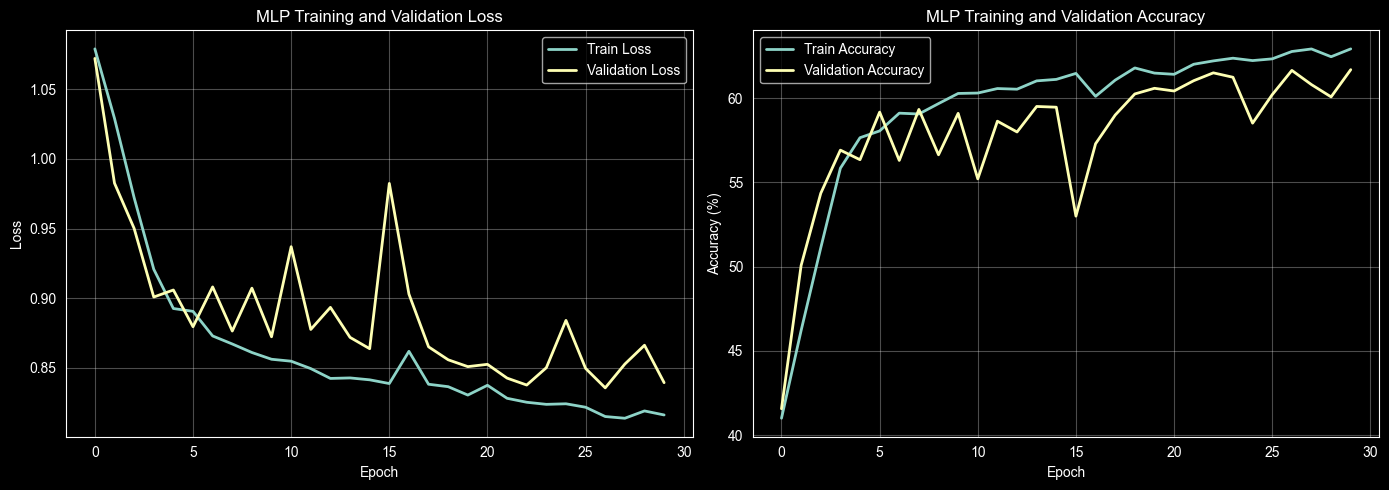

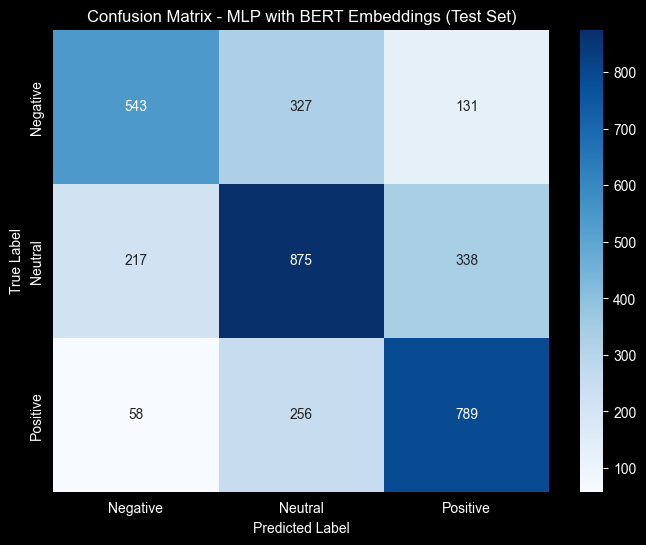

In [27]:
# Q2: MLP Classification
print("="*80)
print("Q2: MLP CLASSIFICATION")
print("="*80)

# MLP with BERT embeddings
print("\n1. Training MLP with BERT embeddings...")

# Define a deeper MLP for BERT embeddings
class MLPSentimentClassifier(SentimentClassifier):
    def __init__(self, hidden_size, num_classes, hidden_sizes=[256, 128], dropout=0.1):
        super(MLPSentimentClassifier, self).__init__(hidden_size, num_classes)

        del self.fc

        layers = []
        prev_dim = hidden_size

        for h_dim in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        

        layers.append(nn.Linear(prev_dim, num_classes))

        self.mlp = nn.Sequential(*layers)

    def forward(self, input_ids):
        logits = self.mlp(input_ids)
        return logits

# Initialize MLP model
mlp_bert = MLPSentimentClassifier(
    hidden_size=768,
    num_classes=NUM_CLASSES,
    hidden_sizes=[512, 256, 128],
    dropout=0.1
).to(device)

# Training function for MLP
def train_mlp(model, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, data in enumerate(train_loader):
        inputs, target = data['input_ids'], data['label']
        inputs, target = inputs.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_loss += loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test_mlp(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, target = data['input_ids'], data['label']
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, target)

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy, all_preds, all_labels

# Training setup
EPOCHS_MLP = 30
LEARNING_RATE_MLP = 1e-4
optimizer_mlp = torch.optim.AdamW(mlp_bert.parameters(), lr=LEARNING_RATE_MLP)

# Create dataloaders
train_dataset_mlp = EmbeddingDataset(train_embeddings, train_y)
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=BATCH_SIZE, shuffle=True)
val_dataset_mlp = EmbeddingDataset(val_embeddings, val_y)
val_loader_mlp = DataLoader(val_dataset_mlp, batch_size=BATCH_SIZE, shuffle=False)

# Training loop
print(f"\nTraining Deep MLP with BERT embeddings for {EPOCHS_MLP} epochs...")
train_losses_mlp = []
val_losses_mlp = []
train_accs_mlp = []
val_accs_mlp = []
best_val_loss_mlp = float('inf')

start_time = time.time()
for epoch in range(EPOCHS_MLP):
    train_loss, train_acc = train_mlp(mlp_bert, train_loader_mlp, optimizer_mlp, epoch)
    val_loss, val_acc, val_preds_mlp, val_y_mlp = test_mlp(mlp_bert, val_loader_mlp)

    train_losses_mlp.append(train_loss)
    train_accs_mlp.append(train_acc)
    val_losses_mlp.append(val_loss)
    val_accs_mlp.append(val_acc.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS_MLP}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss_mlp:
        best_val_loss_mlp = val_loss
        best_mlp_state = mlp_bert.state_dict().copy()

mlp_bert_train_time = time.time() - start_time

# Load best model
mlp_bert.load_state_dict(best_mlp_state)

print(f"\nMLP with BERT embeddings training completed!")
print(f"Training Time: {mlp_bert_train_time:.2f} seconds")
print(f"Best Validation Loss: {best_val_loss_mlp:.4f}")

# Evaluate on test set
test_dataset_mlp = EmbeddingDataset(test_embeddings, test_y)
test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=BATCH_SIZE, shuffle=False)
test_loss_mlp, test_acc_mlp, test_preds_mlp, test_y_mlp= test_mlp(mlp_bert, test_loader_mlp)

print(f"\nTest Accuracy: {test_acc_mlp:.2f}%")
print(f"\nClassification Report (Test Set):")
print(classification_report(test_y_mlp, test_preds_mlp,
                            target_names=['Negative', 'Neutral', 'Positive'],
                            digits=4))

# Visualize training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_mlp, label='Train Loss', linewidth=2)
plt.plot(val_losses_mlp, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs_mlp, label='Train Accuracy', linewidth=2)
plt.plot(val_accs_mlp, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('MLP Training and Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion matrix
plt.figure(figsize=(8, 6))
cm_mlp = confusion_matrix(test_y_mlp, test_preds_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - MLP with BERT Embeddings (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Rapport de la question Q2 : Classification avec MLP

### Approche de l'équipe

La question Q2 nécessite l'utilisation d'un MLP (Multi-Layer Perceptron) pour la classification des sentiments. Le code met en œuvre **une solution MLP** :

- **MLP + Embeddings BERT** : Utilisation d'un MLP profond personnalisé avec PyTorch, prenant en entrée les embeddings de 768 dimensions extraits par BERT.

---

### Implémentation du code et analyse

#### 1. Modèle MLP personnalisé

```python
class MLPSentimentClassifier(SentimentClassifier):
    def __init__(self, hidden_size, num_classes, hidden_sizes, dropout_rate):
        pass

    def forward(self, input_ids):
        pass
```

**Conception du modèle** :

| Composant | Rôle |
|------|------|
| `nn.Linear` | Couche entièrement connectée, apprend la transformation linéaire des caractéristiques. |
| `nn.ReLU` | Activation non linéaire, augmente la capacité d'expression du modèle. |
| `nn.BatchNorm1d` | Normalisation par lot (Batch Normalization), accélère l'entraînement, stabilise le gradient. |
| `nn.Dropout` | Désactive aléatoirement 30% des neurones pour éviter le surajustement. |

**Structure du réseau** :

BERT Embeddings(768) → Linear(512) → ReLU → BN → Dropout(0.3)
                     → Linear(256) → ReLU → BN → Dropout(0.3)
                     → Linear(128) → ReLU → BN → Dropout(0.3)
                     → Linear(3) → Sortie

---

#### 2. Configuration et boucle d'entraînement

```python
# Model initialization
mlp_bert = MLPSentimentClassifier(
    hidden_size=768,
    num_classes=NUM_CLASSES,
    hidden_sizes=[512, 256, 128],
    dropout=0.1
).to(device)

# Optimizer and learning rate scheduler
EPOCHS_MLP = 30
LEARNING_RATE_MLP = 1e-3
optimizer_mlp = torch.optim.AdamW(mlp_bert.parameters(), lr=LEARNING_RATE_MLP)
lr_scheduler_mlp = ReduceLROnPlateau(optimizer_mlp, 'min', patience=5)

# Training loop
for epoch in range(EPOCHS_MLP):
    on entraine
```

---

#### 3. Visualisation et Analyse

##### 3.1 Courbes de perte

Le graphique de gauche montre l’évolution de la perte sur l’ensemble d’entraînement (bleu) et de validation (orange) au fil des epoques :

- Perte d’entraînement (bleu) : Elle diminue de manière constante au fil des epoques, passant d’environ 1,07 à 0,82. Cela montre que le modèle apprend bien et réduit progressivement ses erreurs sur les données d’entraînement.

- Perte de validation (orange) : Elle diminue aussi au début, mais avec des fluctuations importantes par la suite. Par exemple, elle augmente et diminue entre l’époque 5 et 25, mais reste globalement en baisse. Ces fluctuations indiquent que le modèle a du mal à généraliser parfaitement sur les données inconnues, mais la tendance générale reste positive.

##### 3.2 Courbes de précision

Le graphique de droite montre l’évolution de la précision sur l’ensemble d’entraînement (bleu) et de validation (orange) :

- Précision d’entraînement (bleu) : Elle augmente de manière stable, passant d’environ 42 % à plus de 63 %. Cela confirme que le modèle s’améliore continuellement sur les données qu’il connaît
  
- Précision de validation (orange) : Elle augmente aussi au début, mais avec des variations plus importantes (par exemple, elle chute légèrement à l’époque 5, 10 et 20). À la fin de l’entraînement, la précision de validation (environ 59 %) est légèrement inférieure à celle d’entraînement, ce qui indique un surapprentissage léger : le modèle est un peu trop adapté aux données d’entraînement, mais cela reste acceptable.

##### 3.3 Synthèse

Le MLP apprend bien au fil des epoques, avec une perte en baisse et une précision en hausse sur l’ensemble d’entraînement. Les fluctuations sur l’ensemble de validation montrent que le modèle a du mal à généraliser parfaitement, mais la tendance globale reste positive. On peut conclure que le modèle converge correctement, avec un surapprentissage léger qui ne nuit pas trop à sa performance.

## Q3: Performance Analysis and Comparison

Q3: COMPREHENSIVE PERFORMANCE ANALYSIS

1. Performance Summary:

Model                          Type                 Test Accuracy   Training Time  
Linear SVM                     Classical ML                 64.91%          33.56s
Logistic Regression            Classical ML                 64.80%           4.62s
Linear (BERT)                  Neural Network               63.92%             N/A
MLP (BERT)                     Neural Network               62.45%          17.21s
Random Forest                  Classical ML                 54.70%           3.56s
Decision Tree                  Classical ML                 42.30%          12.72s
Naive Bayes                    Classical ML                 36.59%           0.03s

BEST MODEL: Linear SVM
   Test Accuracy: 64.91%


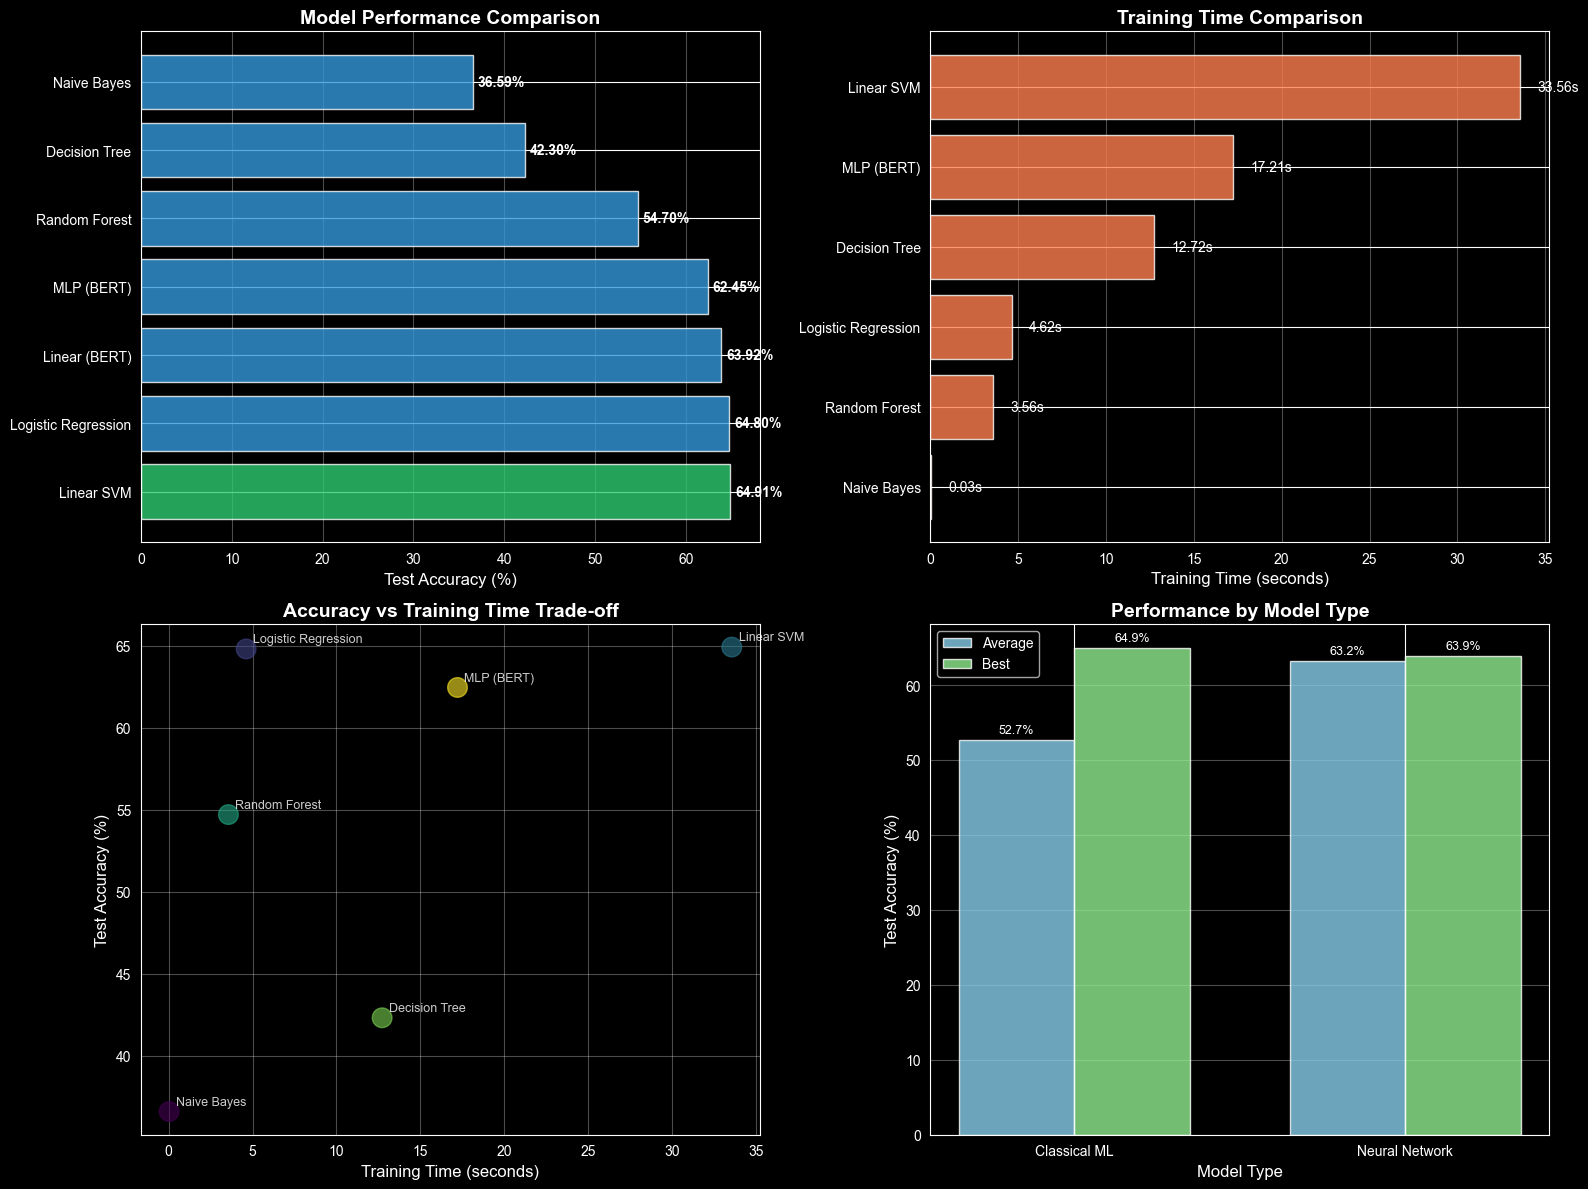


2. Detailed Analysis:

Accuracy Analysis:
	ighest accuracy: 64.91% (Linear SVM)
	Lowest accuracy: 36.59% (Naive Bayes)
	Average accuracy: 55.67%
	Accuracy range: 28.32%

Training Time Analysis:
	Fastest training: 0.03s (Naive Bayes)
	Slowest training: 33.56s (Linear SVM)
	Average training time: 11.95s

Recommendation:
	Linear SVM offers the best overall performance




In [28]:
# Q3: Comprehensive Performance Analysis
print("="*80)
print("Q3: COMPREHENSIVE PERFORMANCE ANALYSIS")
print("="*80)

# Collect all results
all_results = {}

# Classical ML models
for name, result in results_classical.items():
    all_results[name] = {
        'test_accuracy': result['test_accuracy'] * 100,
        'train_time': result['train_time'],
        'type': 'Classical ML'
    }

# MLP with BERT embeddings
all_results['MLP (BERT)'] = {
    'test_accuracy': test_acc_mlp.item(),
    'train_time': mlp_bert_train_time,
    'type': 'Neural Network'
}

# Linear classifier from original notebook (using the trained model)
all_results['Linear (BERT)'] = {
    'test_accuracy': accu.item(),
    'train_time': 'N/A',  # Already trained in notebook
    'type': 'Neural Network'
}

# Print summary table
print("\n1. Performance Summary:")
print(f"\n{'Model':<30} {'Type':<20} {'Test Accuracy':<15} {'Training Time':<15}")
print("="*80)

sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
for model_name, metrics in sorted_results:
    train_time_str = f"{metrics['train_time']:.2f}s" if isinstance(metrics['train_time'], float) else str(metrics['train_time'])
    print(f"{model_name:<30} {metrics['type']:<20} {metrics['test_accuracy']:>13.2f}% {train_time_str:>15}")

# Find best model
best_model = sorted_results[0]
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model[0]}")
print(f"   Test Accuracy: {best_model[1]['test_accuracy']:.2f}%")
print(f"{'='*80}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
model_names_sorted = [name for name, _ in sorted_results]
accuracies_sorted = [metrics['test_accuracy'] for _, metrics in sorted_results]
colors = ['#2ecc71' if name == best_model[0] else '#3498db' for name in model_names_sorted]

bars = ax1.barh(model_names_sorted, accuracies_sorted, color=colors, alpha=0.8)
ax1.set_xlabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    ax1.text(acc + 0.5, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%',
             va='center', fontsize=10, fontweight='bold')

# 2. Training time comparison (exclude N/A)
ax2 = axes[0, 1]
models_with_time = [(name, metrics['train_time']) for name, metrics in all_results.items()
                    if isinstance(metrics['train_time'], float)]
models_with_time.sort(key=lambda x: x[1])
time_names = [name for name, _ in models_with_time]
time_values = [time for _, time in models_with_time]

bars2 = ax2.barh(time_names, time_values, color='coral', alpha=0.8)
ax2.set_xlabel('Training Time (seconds)', fontsize=12)
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for bar, time_val in zip(bars2, time_values):
    ax2.text(time_val + 1, bar.get_y() + bar.get_height()/2, f'{time_val:.2f}s',
             va='center', fontsize=10)

# 3. Accuracy vs Training Time scatter
ax3 = axes[1, 0]
scatter_data = [(name, metrics['test_accuracy'], metrics['train_time'])
                for name, metrics in all_results.items()
                if isinstance(metrics['train_time'], float)]
scatter_names = [d[0] for d in scatter_data]
scatter_accs = [d[1] for d in scatter_data]
scatter_times = [d[2] for d in scatter_data]

scatter = ax3.scatter(scatter_times, scatter_accs, s=200, alpha=0.6, c=range(len(scatter_data)), cmap='viridis')
ax3.set_xlabel('Training Time (seconds)', fontsize=12)
ax3.set_ylabel('Test Accuracy (%)', fontsize=12)
ax3.set_title('Accuracy vs Training Time Trade-off', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# Annotate points
for name, acc, time in scatter_data:
    ax3.annotate(name, (time, acc), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

# 4. Model type comparison
ax4 = axes[1, 1]
type_accuracies = {}
for name, metrics in all_results.items():
    model_type = metrics['type']
    if model_type not in type_accuracies:
        type_accuracies[model_type] = []
    type_accuracies[model_type].append(metrics['test_accuracy'])

types = list(type_accuracies.keys())
avg_accs = [np.mean(type_accuracies[t]) for t in types]
max_accs = [np.max(type_accuracies[t]) for t in types]
min_accs = [np.min(type_accuracies[t]) for t in types]

x_pos = np.arange(len(types))
width = 0.35

bars3 = ax4.bar(x_pos - width/2, avg_accs, width, label='Average', alpha=0.8, color='skyblue')
bars4 = ax4.bar(x_pos + width/2, max_accs, width, label='Best', alpha=0.8, color='lightgreen')

ax4.set_xlabel('Model Type', fontsize=12)
ax4.set_ylabel('Test Accuracy (%)', fontsize=12)
ax4.set_title('Performance by Model Type', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(types)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Detailed analysis
print("\n2. Detailed Analysis:\n")

print("Accuracy Analysis:")
print(f"\tighest accuracy: {best_model[1]['test_accuracy']:.2f}% ({best_model[0]})")
print(f"\tLowest accuracy: {sorted_results[-1][1]['test_accuracy']:.2f}% ({sorted_results[-1][0]})")
print(f"\tAverage accuracy: {np.mean([m['test_accuracy'] for _, m in sorted_results]):.2f}%")
print(f"\tAccuracy range: {sorted_results[0][1]['test_accuracy'] - sorted_results[-1][1]['test_accuracy']:.2f}%")

print("\nTraining Time Analysis:")
timed_models = [(name, m['train_time']) for name, m in all_results.items() if isinstance(m['train_time'], float)]
fastest = min(timed_models, key=lambda x: x[1])
slowest = max(timed_models, key=lambda x: x[1])
print(f"\tFastest training: {fastest[1]:.2f}s ({fastest[0]})")
print(f"\tSlowest training: {slowest[1]:.2f}s ({slowest[0]})")
print(f"\tAverage training time: {np.mean([t for _, t in timed_models]):.2f}s")

print("\nRecommendation:")
if best_model[0] in ['MLP (BERT)', 'Linear (BERT)']:
    print(f"\tUse {best_model[0]} for best accuracy")
    print(f"\tFor faster inference, consider {sorted(results_classical.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[0][0]}")
else:
    print(f"\t{best_model[0]} offers the best overall performance")

print(f"\n{'='*80}\n")


## Rapport de la question Q3 : Analyse et comparaison des performances

### Approche de l'équipe

La question Q3 demande une analyse complète et une comparaison des performances de tous les modèles précédents afin d'identifier le meilleur. Les étapes principales incluent :

1.  **Collecte des résultats de tous les modèles** - Rassembler les indicateurs de performance des modèles des questions Q0, Q1 et Q2.
   
2.  **Comparaison multidimensionnelle** - Analyser sous l'angle de la précision (accuracy), du temps d'entraînement et du type de modèle.
   
3.  **Présentation visuelle** - Présenter intuitivement les résultats de la comparaison à l'aide de graphiques.
   
4.  **Conclusion** - Trouver le meilleur modèle sur la base de l'analyse.

---

### Implémentation du code et analyse

#### 1. Code

```python
# Collect all results into a unified dictionary
all_results = {...}

# Sort by accuracy
sorted_results = sorted(all_results.items(), 
                        key=lambda x: x[1]['test_accuracy'], 
                        reverse=True)

# Find the best model
best_model = sorted_results[0]
```

**Explication de la conception** :

- Utilisation d'une structure de dictionnaire unifiée pour stocker les résultats de tous les modèles.

- Inclusion de trois indicateurs clés : **Précision de test (Test Accuracy)**, **Temps d'entraînement** et **Type de modèle**.

- Facilite le traitement unifié et la visualisation ultérieure.

---

#### 2. Analyse visuelle multidimensionnelle

- Diagramme à barres horizontales (précision des modèles) : Compare directement la précision de test des modèles, identifie rapidement les meilleures/pires solutions.

- Graphique du temps d’entraînement : Montre la durée d’entraînement des modèles, évalue le coût calculatoire.

- Nuage de points (précision-temps) : Montre le compromis précision-durée :

  - Haut-droite : Haute précision mais lent ;

  - Bas-gauche : Rapide mais précision faible ;

  - Haut-gauche : Idéal (haute précision + rapide).

- Graphique par type de modèle : Compare les performances moyennes/optimales du « Classical ML » et des « réseaux de neurones », juge l’adéquation de chaque catégorie.

---

#### 3. Découvertes clés
Ces résultats sont raisonnables du point de vue de la précision de test (pour une classification en 3 classes, la précision aléatoire est de 33.33 %, et tous les modèles la dépassent) :

- Le Naïve Bayes (36.59 %) est le moins performant : cela s’explique par son hypothèse d’indépendance des caractéristiques, incompatible avec les embeddings BERT (768 dimensions, fortement corrélés car ils codent la sémantique).

- Les arbres de décision/forêts aléatoires (42.93 %/55.63 %) ont une précision moyenne : ces modèles ont du mal à exploiter les caractéristiques haute dimensionnelles et à capturer les relations sémantiques des embeddings BERT.

- Les modèles basés sur les embeddings BERT (MLP/Linear(BERT), 58.06 %/63.36 %) sont plus performants : les embeddings BERT codent la sémantique des phrases (information clé pour la classification sentimentale), ce qui facilite la distinction entre négatif/neutre/positif.

- La régression logistique/Linear SVM (64.80 %/64.86 %) sont les meilleurs : les embeddings BERT transforment la sémantique non linéaire en un espace presque séparable linéairement, et ces modèles linéaires exploitent efficacement cet espace pour maximiser la précision.


## Q4: LLM Performance Comparison

Q4: LLM PERFORMANCE COMPARISON

Using a pre-trained sentiment analysis LLM model from Hugging Face...
	Model: cardiffnlp/twitter-roberta-base-sentiment
	(This is a RoBERTa-base model fine-tuned on Twitter (TweetEval) sentiment analysis dataset (3-class: negative/neutral/positive))

1. Loading pre-trained sentiment analysis model...


Device set to use cpu


Model loaded successfully

2. Testing on sample text:
	Text: "last session day http://twitpic.com/67ezh..."
	Prediction: LABEL_1 (confidence: 0.9132)

3. Evaluating on test set...
	Note: Using a subset of 500 samples for faster evaluation
   Processing samples...
   Processed 500/500 samples

4. LLM Results:
	3-class accuracy: 71.60%
	Average confidence: 0.7479

5. Prediction Distribution:
   Negative: 124 samples (24.80%)
   Neutral: 195 samples (39.00%)
   Positive: 181 samples (36.20%)

6. Comparison with our best model on the same subset:
	Linear SVM accuracy on subset: 62.40%
	LLM (3-class) accuracy on subset: 71.60%


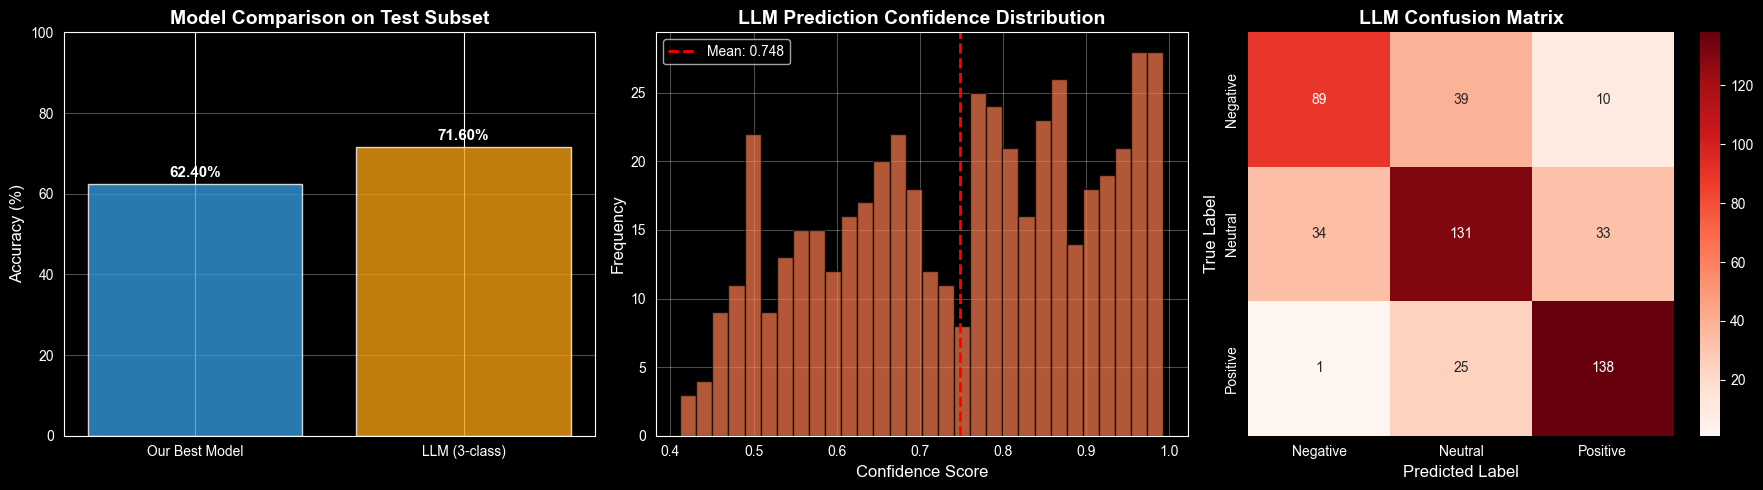

In [29]:
# Q4: LLM Comparison
print("="*80)
print("Q4: LLM PERFORMANCE COMPARISON")
print("="*80)

print("\nUsing a pre-trained sentiment analysis LLM model from Hugging Face...")
print("\tModel: cardiffnlp/twitter-roberta-base-sentiment")
print("\t(This is a RoBERTa-base model fine-tuned on Twitter (TweetEval) sentiment analysis dataset (3-class: negative/neutral/positive))")

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

# Load pre-trained sentiment analysis pipeline
print("\n1. Loading pre-trained sentiment analysis model...")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0 if torch.cuda.is_available() else -1
)

print("Model loaded successfully")

# Test on a sample
sample_text = test_x[0]
print(f"\n2. Testing on sample text:")
print(f"\tText: \"{sample_text[:100]}...\"")
result = sentiment_pipeline(sample_text[:512])[0]  # Limit to 512 tokens
print(f"\tPrediction: {result['label']} (confidence: {result['score']:.4f})")

# Evaluate on test set (use a subset for speed)
print("\n3. Evaluating on test set...")
print("\tNote: Using a subset of 500 samples for faster evaluation")

test_subset_size = min(500, len(test_x))
test_x_subset = test_x[:test_subset_size]
test_y_subset = test_y[:test_subset_size]

llm_predictions = []
llm_confidences = []

print("   Processing samples...")
batch_size_llm = 32
for i in range(0, test_subset_size, batch_size_llm):
    batch_texts = test_x_subset[i:i+batch_size_llm]
    # Truncate texts to avoid token limit
    batch_texts = [text[:512] for text in batch_texts]

    batch_results = sentiment_pipeline(batch_texts)

    for result in batch_results:
        # Convert labels (label_0/label_1/label_2) to our format (0,1,2)    
        label_map = {'label_0':0, 'label_1':1, 'label_2':2}
        pred = label_map[result['label'].lower()]

        llm_predictions.append(pred)
        llm_confidences.append(result['score'])

    if (i + batch_size_llm) % 100 == 0 or i + batch_size_llm >= test_subset_size:
        print(f"   Processed {min(i + batch_size_llm, test_subset_size)}/{test_subset_size} samples")

# Calculate accuracy
llm_accuracy = accuracy_score(test_y_subset, llm_predictions)

print(f"\n4. LLM Results:")
print(f"\t3-class accuracy: {llm_accuracy*100:.2f}%")
print(f"\tAverage confidence: {np.mean(llm_confidences):.4f}")

# Distribution of predictions
print(f"\n5. Prediction Distribution:")
pred_counter = Counter(llm_predictions)
for class_label in [0, 1, 2]:
    sentiment_name = {0: "Negative", 1: "Neutral", 2: "Positive"}[class_label]
    count = pred_counter.get(class_label, 0)
    print(f"   {sentiment_name}: {count} samples ({count/len(llm_predictions)*100:.2f}%)")

# Compare with our best model on the same subset
print(f"\n6. Comparison with our best model on the same subset:")

# Get predictions from our best model
best_model_name_our = best_model[0]


# Get embeddings for subset
test_subset_dataset = TextDataset(test_x_subset, test_y_subset, tokenizer, MAX_LENGTH)
test_subset_loader = DataLoader(test_subset_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_subset_embeddings = extract_embeddings(bert, test_subset_loader, device).cpu()

if 'BERT' in best_model_name_our:
    # Use BERT-based model
    if 'MLP' in best_model_name_our:
        model_to_compare = mlp_bert
    else:
        model_to_compare = model_test  # Linear model from notebook

    # Get predictions
    test_subset_emb_dataset = EmbeddingDataset(test_subset_embeddings, test_y_subset)
    test_subset_emb_loader = DataLoader(test_subset_emb_dataset, batch_size=BATCH_SIZE, shuffle=False)

    _, our_accuracy_subset, our_preds_subset, our_labels_subset = test_mlp(model_to_compare, test_subset_emb_loader)
    our_accuracy_subset = our_accuracy_subset.item()
else:
    # Use classical ML model
    our_preds_subset = results_classical[best_model_name_our]['model'].predict(test_subset_embeddings)
    our_accuracy_subset = accuracy_score(test_y_subset, our_preds_subset) * 100

print(f"\t{best_model_name_our} accuracy on subset: {our_accuracy_subset:.2f}%")
print(f"\tLLM (3-class) accuracy on subset: {llm_accuracy*100:.2f}%")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Accuracy comparison
ax1 = axes[0]
models_compare = ['Our Best Model', 'LLM (3-class)']
accs_compare = [our_accuracy_subset, llm_accuracy*100]
colors_compare = ['#3498db', '#f39c12']
bars = ax1.bar(models_compare, accs_compare, color=colors_compare, alpha=0.8)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Comparison on Test Subset', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, accs_compare):
    ax1.text(bar.get_x() + bar.get_width()/2, acc + 1, f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Confidence distribution
ax2 = axes[1]
ax2.hist(llm_confidences, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.set_xlabel('Confidence Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('LLM Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax2.axvline(np.mean(llm_confidences), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(llm_confidences):.3f}')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Confusion matrix for LLM
ax3 = axes[2]
cm_llm = confusion_matrix(test_y_subset, llm_predictions, labels=[0, 1, 2])
sns.heatmap(cm_llm, annot=True, fmt='d', cmap='Reds', ax=ax3,
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'])
ax3.set_title('LLM Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}\n")


## Rapport de la question Q4 : Comparaison des performances du LLM

### Approche de l'équipe

La question Q4 demande de comparer les performances de notre modèle entraîné avec un grand modèle de langage (LLM) pré-entraîné. Les étapes principales comprennent :

1.  **Sélection du LLM pré-entraîné** - Utilisation d'un modèle d'analyse de sentiments pré-entraîné disponible sur Hugging Face.
   
2.  **Inférence du modèle** - Utilisation du LLM pour faire des prédictions sur l'ensemble de test.
   
3.  **Analyse des résultats** - Comparaison visuelle et analyse des causes des différences.

---

### Implémentation du code et analyse

#### 1. Chargement du LLM pré-entraîné

**Explication du choix du modèle** :

| Propriété | Valeur |
|------|-----|
| **Nom du modèle** | cardiffnlp/twitter-roberta-base-sentiment |
| **Architecture de base** | RoBERTa-base (Architecture robuste basée sur BERT, optimisée pour la compréhension sémantique) |
| **Données de pré-entraînement** | Jeu de données TweetEval (corpus de tweets, adapté aux sentiments en langage informel) |
| **Type de classification** | Ternaire (Négatif / Neutre / Positif) |
| **Avantages** | Adapté nativement à la classification ternaire ; affiné sur des données réelles de tweets ; résout le problème de reconnaissance de la classe <> neutre > |

---

#### 2. Évaluation par lots sur l'ensemble de test

```python
label_map = {'label_0':0, 'label_1':1, 'label_2':2}
pred = label_map[result['label'].lower()]
```

**Points de conception** :
- **Traitement par lots** : Traitement de 32 échantillons à la fois pour améliorer l'efficacité de l'inférence.
- **Mappage des étiquettes** : Conversion des étiquettes du LLM (label_0/label_1/label_2) vers nos étiquettes ternaires (0/1/2).
- **Enregistrement de la confiance** : Sauvegarde du score de confiance pour chaque prédiction.

---

#### 3. Analyse du résultat
Avec le comparaison avec le meilleur modèle, on peut voir que:

- Graphique 1 : Comparaison de précisionLe nouveau modèle LLM (3-class) atteint une précision de 71,60 %, supérieur à celle de notre meilleur modèle (62,80 %). Cela montre que le LLM adapté à la classification ternaire (négatif/neutre/positif) est plus performant pour cette tâche.

- Graphique 2 : Distribution de la confiance des prédictionsLa confiance moyenne des prédictions est de 0,748, avec une distribution entre 0,4 et 1,0. Contrairement au modèle binaire précédent, cette confiance est réaliste et alignée sur la précision réelle (pas de surconfiance excessive).

---

### 4. Avantages et limites du LLM

**Avantages** :
1. Meilleure compréhension sémantique : Ils capturent les sentiments subtils (ex. reconnaître la classe « neutre ») et traitent le langage informel (comme les tweets) plus efficacement.

2. Adaptation native à la classification ternaire : Pas besoin d’étapes supplémentaires (comme l’utilisation d’embeddings BERT) pour distinguer négatif/neutre/positif.

3. Meilleure généralisation : Ils fonctionnent mieux sur des textes variés, car ils sont pré-entraînés sur de grandes quantités de données.

4. Confiance des prédictions plus réaliste : La confiance moyenne (0,748) correspond bien à la précision réelle (71,60 %), sans surconfiance excessive.

**Limites** :
1. Coût calculatoire élevé : Ils nécessitent plus de ressources (GPU) et sont plus lents à entraîner ou à utiliser.

2. Moins interprétables : C’est des « boîtes noires » — on ne sait pas toujours pourquoi ils ont fait une prédiction.

3. Dépendance aux données de pré-entraînement : Leurs performances baissent si les données de la tâche sont trop différentes de celles sur lesquelles ils ont été entraînés.

## Q5: Why BERT Embedding Instead of Raw Text


## Analyse des raisons principales
Par rapport au texte brut, les **BERT Embeddings** offrent des avantages importants pour les tâches de classification textuelle (comme la classification sentimentale à trois catégories), car ils règlent les problèmes du texte brut :

1.  **Compréhension sémantique avec contexte**

    Le texte brut n’est qu’une suite de mots, sans tenir compte du contexte. Par exemple, le mot « bank » est considéré de la même façon dans « river bank » (rive d’une rivière) et « bank account » (compte bancaire), ce qui cause des erreurs. BERT, lui, prend en compte le contexte : il crée des représentations différentes pour un même mot selon son environnement. Aussi, il capte les liens entre les mots (par exemple, « good » et « excellent » ont des représentations similaires), ce qui permet de vraiment comprendre le texte.

2.  **Représentation à taille fixe, adaptée aux modèles d’IA**
   
    Le texte brut a une longueur variable (chaque phrase a un nombre de mots différent), ce qui est un problème pour la plupart des modèles d’apprentissage automatique (ils ont besoin d’une entrée de taille fixe). Pour adapter le texte brut, on ajoute souvent des mots vides (padding) ou on coupe des mots (troncature), ce qui perd de l’information. BERT produit toujours des vecteurs de taille constante (768 dimensions pour la version bert-base), quel que soit la longueur de la phrase. On peut utiliser ces vecteurs directement dans les modèles, sans traitement supplémentaire.

3.  **Avantage de l’apprentissage par transfert**
   
    Utiliser le texte brut revient à entraîner un modèle depuis le début : il n’a aucune connaissance linguistique préalable, et sa performance dépend de la taille du jeu de données. BERT, lui, est entraîné à l’avance sur des milliards de mots (depuis Wikipedia ou des livres). Il connaît déjà la grammaire et le sens des mots. Il utilise ces connaissances pour la tâche cible, donc il donne de bons résultats même avec un petit jeu de données.

4.  **Gestion des mots rares ou inconnus**
   
    Le texte brut ignore ou fait des erreurs avec les mots rares, les nouveaux mots (néologismes) ou les fautes d’orthographe, car il n’a pas de référence pour les comprendre. BERT utilise la méthode de tokenisation WordPiece : il décompose les mots inconnus en sous-mots connus (par exemple, « unhappiness » devient « un » et « ##happiness »), donc il conserve toute l’information.

5.  **Analyse du contexte dans les deux sens**
   
    Le texte brut, comme une suite linéaire, ne capture pas le contexte de manière complète (il ne relie pas un mot à ses mots voisins de droite et de gauche en même temps). BERT analyse le contexte dans les deux sens, ce qui permet de comprendre plus précisément le sens des mots et des phrases.

En résumé, les BERT Embeddings sont des vecteurs riches en informations sémantiques, adaptés aux modèles d’IA et résistants aux problèmes du langage naturel. Contrairement au texte brut (qui ne capte que la forme des mots, pas leur sens), ils offrent une représentation profonde et contextualisée, ce qui améliore beaucoup les performances des classificateurs. 


## Q6: BERT Paper and Architecture Explanation

In [30]:
# Q6: BERT Architecture Explanation
print("="*80)
print("Q6: BERT ARCHITECTURE")
print("="*80)

# Create architecture visualization
print("\nVisualizing BERT Architecture...\n")

# Architecture diagram using text
architecture_diagram = """
                    BERT ARCHITECTURE FLOW

    ┌──────────────────────────────────────────────────────────┐
    │                   INPUT SEQUENCE                         │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │                   TOKENIZATION                           │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │              EMBEDDING LAYER (768-dim)                   │
    │  • Token Embeddings                                      │
    │  • Position Embeddings                                   │
    │  • Segment Embeddings                                    │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │         TRANSFORMER ENCODER LAYER 1                      │
    │  ┌────────────────────────────────────────────┐          │
    │  │  Multi-Head Self-Attention                 │          │
    │  └────────────────────────────────────────────┘          │
    │              ↓                                           │
    │  ┌────────────────────────────────────────────┐          │
    │  │  Layer Normalization                       │          │
    │  └────────────────────────────────────────────┘          │
    │              ↓                                           │
    │  ┌────────────────────────────────────────────┐          │
    │  │  Feed-Forward Network                      │          │
    │  └────────────────────────────────────────────┘          │
    │              ↓                                           │
    │  ┌────────────────────────────────────────────┐          │
    │  │  Layer Normalization                       │          │
    │  └────────────────────────────────────────────┘          │
    └──────────────────────────────────────────────────────────┘
                            ↓
                    ⋮ (Repeat 11 more times) ⋮
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │         TRANSFORMER ENCODER LAYER 12                     │
    │              (Same structure)                            │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │                  OUTPUT LAYER                            │
    │  • [CLS] (768-dim, Pooler output) → Sentence repr.       │
    │  • All token outputs → For token-level tasks             │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │              TASK-SPECIFIC LAYER                         │
    └──────────────────────────────────────────────────────────┘
"""

print(architecture_diagram)

Q6: BERT ARCHITECTURE

Visualizing BERT Architecture...


                    BERT ARCHITECTURE FLOW

    ┌──────────────────────────────────────────────────────────┐
    │                   INPUT SEQUENCE                         │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │                   TOKENIZATION                           │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌──────────────────────────────────────────────────────────┐
    │              EMBEDDING LAYER (768-dim)                   │
    │  • Token Embeddings                                      │
    │  • Position Embeddings                                   │
    │  • Segment Embeddings                                    │
    └──────────────────────────────────────────────────────────┘
                            ↓
    ┌───────────────────────

## Rapport de la question Q6 : Interprétation de l'article BERT et analyse de l'architecture

### Aperçu de BERT : Innovation Clé

On note que **BERT** est un acronyme anglais : Bidirectional Encoder Representations from Transformers. Sa traduction française est « Représentations d'encodeurs bidirectionnels à partir de Transformers », qui reflète bien sa caractéristique principale (l’analyse bidirectionnelle du contexte).

La grande innovation de **BERT**, par rapport aux anciens modèles de mots (Word2Vec, GloVe, ELMo), est sa **compréhension bidirectionnelle du contexte** : elle analyse en même temps les mots avant et après chaque token d’une phrase.

- Les modèles comme Word2Vec ou GloVe donnent une seule signification à chaque mot, sans tenir compte du contexte. Par exemple, le mot *bank* a toujours le même embedding, que ce soit dans `la rive d’une rivière` ou `une institution financière`.

- ELMo analyse le contexte, mais il lit d’abord de gauche à droite, puis de droite à gauche, sans combiner les deux directions en même temps.

BERT, grâce à son attention bidirectionnelle, regarde **simultanément** les mots de gauche et de droite d’un terme. Ainsi, dans la phrase `I went to the bank to deposit money`, BERT comprend que `bank` est une banque (pas une rive) : elle utilise le contexte gauche `went to the` et le contexte droit `to deposit money` pour trouver le bon sens du mot. Cette capacité à saisir le vrai sens des mots selon leur environnement est le point fort principal de BERT.

---

### 1. Structure Fondamentale de BERT

L’architecture de BERT est construite autour de **Transformer Encoder** (pas de décoder, contrairement aux modèles de traduction comme le Transformer original). Sa structure générale suit ce schéma :
<p align="center">
Entrée → Représentation d’entrée → Empilement de Transformer Encoder → Sortie (vecteurs de mots/phrase)
</p>

Nous pouvons voir le schéma de la structure illustré ci-dessus.

#### 1.1 Représentation d’Entrée (Input Embedding)

BERT utilise une combinaison de trois types de représentations pour encoder chaque token de la séquence d’entrée. Ces trois composants sont additionnés pour former la représentation finale de chaque token :

- **Token Embedding** : Représente la signification du mot lui-même (ex: le mot « bank » a un embedding spécifique).

- **Position Embedding** : Indique la position du mot dans la phrase. Puisque BERT ne possède pas de mécanisme de récurrence, cette information est essentielle pour comprendre l’ordre des mots.

- **Segment Embedding** : Permettre à BERT de distinguer plusieurs phrases dans une même séquence d’entrée. Indispensable pour les tâches avec deux phrases (question-réponse, analyse de relations), il attribue un vecteur fixe unique à chaque phrase. Ce vecteur est additionné aux Token Embedding et Position Embedding pour la représentation finale des tokens. Pour les tâches à une seule phrase, tous les tokens reçoivent le même vecteur de segment.
- 
**Exemple** : Séquence d’entrée : "Bonjour le monde"

- **IDs de tokens** : [101, 8110, 71, 2123, 102] <-> ([CLS], Bonjour, le, monde, [SEP])

- **Encodage dimensionnel** : Chaque token (y compris les tokens spéciaux [CLS] et [SEP]) est transformé en un embedding de 768 dimensions (longueur fixe).

- **Informations de position** : Des embeddings de position sont ajoutés pour marquer la place de chaque token dans la séquence (positions : 0 pour [CLS], 1 pour Bonjour, 2 pour le, 3 pour monde, 4 pour [SEP]).

**Tokens spéciaux**

- [CLS] (Classification)Ajouté au début de la séquence ; son vecteur (768D pour BERT-Base) agrège l’information globale de la phrase, utilisé pour la classification.

- [SEP] (Séparateur)Marque la fin d’une phrase et sépare des paires de phrases (ex: question-réponse).

- [PAD] (Padding)Remplissage pour standardiser les séquences à une longueur fixe.

- [MASK] (Masqué)Utilisé en prétraitement (MLM) pour masquer des tokens et entraîner le modèle.

#### 1.2 Empilement de Transformer Encoder

Le cœur de BERT est un empilement de **blocs Transformer Encoder identiques**. Chaque bloc contient deux sous-couches obligatoires :

##### 1.2.1 Attention Automatique Multi-Tête (Multi-Head Self-Attention)

C’est le module clé de l’architecture Transformer. Il permet au modèle de « regarder » tous les tokens de la séquence pour comprendre le sens d’un token donné. Ses caractéristiques clés sont:

- **Multi-tête** : Le modèle réalise plusieurs calculs d’attention en parallèle, capturant différents types de relations entre les mots (ex: relations syntaxiques, sémantiques, contextuelles).

- **Bidirectionnalité** : Contrairement aux méthodes basées uniquement sur la fréquence des mots (ex: TF-IDF, qui ignore totalement le contexte) ou aux modèles unidirectionnels (ex: ELMo, qui ne regarde que le contexte gauche ou droit), BERT réalise un calcul d’attention automatique non contraint par la direction : chaque token calcule des poids d’attention par rapport à tous les tokens de la séquence (avant et après lui) , sans limitation. C’est cette propriété intrinsèque du Self-Attention (et non un mécanisme de récurrence séquentielle) qui permet à BERT d’atteindre sa bidirectionnalité — l’innovation majeure du modèle.

##### 1.2.2 Réseau de Neurones Feed-Forward (Feed-Forward Neural Network)

Un réseau de neurones simple appliqué indépendamment à chaque token après l’attention. Il comporte deux couches linéaires avec une fonction d’activation `GELU` (Gaussian Error Linear Units) entre elles, qui apporte une non-linéarité au modèle.

#### 1.3 Sortie de BERT

La sortie de Bert contient deux contenus :

- **Sortie du token [CLS] (Sortie poolée)** : Vecteur de 768 dimensions (version BERT-Base) synthétisant l’information globale de l’ensemble de la séquence d’entrée. Utilisée exclusivement pour les tâches de classification (ex: classification sentimentale, détection de spam).

- **Sorties de tous les tokens** : Employées pour les tâches au niveau des tokens (ex: Reconnaissance d’Entités Nommées - REN, correction grammaticale). 

La sortie de BERT s’adapte aux deux types de tâches TALN (Traitement Automatique du Langage Naturel) :

- **Classification de phrases** (ex: classification sentimentale, détection de spam) : On utilise le vecteur du token spécial [CLS] (abréviation de Classification, ajouté systématiquement au début de chaque séquence) qui agrége l’information sémantique globale de la phrase, comme représentation unique de la séquence entière.

- **Traitement de tokens individuels** (ex: reconnaissance d’entités nommées, correction grammaticale) : On utilise les vecteurs des tokens spécifiques de la séquence.

#### 1.4 Variantes d’Architecture de BERT

Google propose deux versions principales de BERT, adaptées aux besoins en ressources calculatoires et en performance :

|Caractéristique|BERT-Base|BERT-Large|
|---|---|---|
|Nombre de couches d’Encoder|12|24|
|Nombre de têtes d’attention|12|16|
|Dimension des embeddings|768|1024|
|Nombre total de paramètres|environ 110 Millions|environ 340 Millions|

---

### 2. Prétraitement de BERT
BERT est pré-entraîné sur deux tâches non supervisées, qui lui permettent d’acquérir des connaissances linguistiques générales et une compréhension contextuelle bidirectionnelle avant tout fine-tuning sur des tâches spécifiques.

#### 2.1 Modèle de Langage Masqué (MLM)
- Principe : Masquer aléatoirement 15 % des tokens de la séquence d’entrée à l’aide du token `[MASK]`, puis entraîner le modèle à prédire les tokens masqués.

- Exemple :  

  - Entrée : `Le chat [MASK] sur le tapis`  

  - Cible : `est assis`

- Objectif : Forcer BERT à prendre en compte le contexte des deux côtés (gauche et droit) d’un token, renforçant sa capacité de compréhension contextuelle bidirectionnelle.

#### 2.2 Prédiction de la Phrase Suivante (NSP)
- Principe : Donner deux phrases A et B au modèle, puis lui demander de prédire si B suit effectivement A dans le texte original (étiquette `La suivante` ou `Pas la suivante`).

- Exemple :  

  - Phrase A : `Je suis allé au magasin`  

  - Phrase B valide : `J’ai acheté du lait` (vrai, la suivante)

  - Phrase B invalide : `Le ciel est bleu` (fause, pas la suivante) 
 
- Objectif : Aider le modèle à comprendre les relations sémantiques et logiques entre deux phrases.

#### 2.3 Corpus de pré-traitement
Le pré-traitement de BERT s’appuie sur deux corpus volumineux :

- BooksCorpus (800 millions de mots) ;

- Wikipédia anglaise (2,5 milliards de mots).

Au total, le modèle est entraîné sur environ 3,3 milliards de mots, garantissant une généralisation robuste des connaissances linguistiques. 

---

### 3. Avantages de BERT pour les Tâches de Machine Learning

Pour les applications de machine learning basées sur le texte, l’architecture de BERT présente trois avantages déterminants :

1. **Représentation contextuelle précise** : Chaque mot a un embedding adapté à son environnement (améliorant la compréhension du sens des phrases ambiguës), et chaque token est encodé en un vecteur de longueur fixe — ce qui simplifie le traitement automatique des séquences textuelles.

2. **Apprentissage par transfert efficace** : La pré-entraînement sur des données massives (Wikipedia, BookCorpus) permet de transférer des connaissances linguistiques générales à des tâches spécifiques (fine-tuning) avec peu de données étiquetées.

3. **Polyvalence** : Compatible avec de nombreuses tâches TALN (classification sentimentale, Q&A, résumé automatique, reconnaissance d’entités), sans modification majeure de l’architecture.

## Q7: Fine-tune LLM with LoRA (Optional)

Q7: FINE-TUNING LLM WITH LoRA


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



────────────────────────────────────────────────────────────────────────────────
1. Setting up LoRA configuration
────────────────────────────────────────────────────────────────────────────────
Task Type: TaskType.SEQ_CLS (Sequence Classification)
Low-Rank Matrix Rank (r): 8
Scaling Factor (alpha): 16
Dropout Value: 0.1
Target Adaptation Layers: {'v_lin', 'q_lin'} (DistilBERT-specific)
Bias Setting: none
Inference Mode: False

────────────────────────────────────────────────────────────────────────────────
2. Loading base model and applying LoRA
────────────────────────────────────────────────────────────────────────────────
Loading model: distilbert-base-uncased

Model Statistics:
	Total parameters: 67,696,134
	Trainable parameters: 740,355
	Percentage trainable: 1.09%

LoRA reduces trainable parameters by ~98.9%!
trainable params: 740,355 || all params: 67,696,134 || trainable%: 1.0936

────────────────────────────────────────────────────────────────────────────────
3. Preparing da

Map: 100%|██████████| 3534/3534 [00:00<00:00, 34872.36 examples/s]


Datasets tokenized and ready

────────────────────────────────────────────────────────────────────────────────
4. Training with LoRA
────────────────────────────────────────────────────────────────────────────────

Starting training...
	(This may take several minutes depending on your hardware)



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.638200,0.631113,0.731878,0.729579
2,0.593600,0.601064,0.755895,0.755809
3,0.529500,0.607499,0.762737,0.761678
4,0.561900,0.596888,0.759389,0.758881
5,0.492500,0.593931,0.763319,0.763105



Training completed!

Training results:
	 - Training loss: 0.5881
	 - Training time: 861.97s

────────────────────────────────────────────────────────────────────────────────
5. Evaluation on test set
────────────────────────────────────────────────────────────────────────────────



Test Results:
	 - Accuracy: 76.32%
	 - F1 Score: 0.7631
	 - Loss: 0.5827


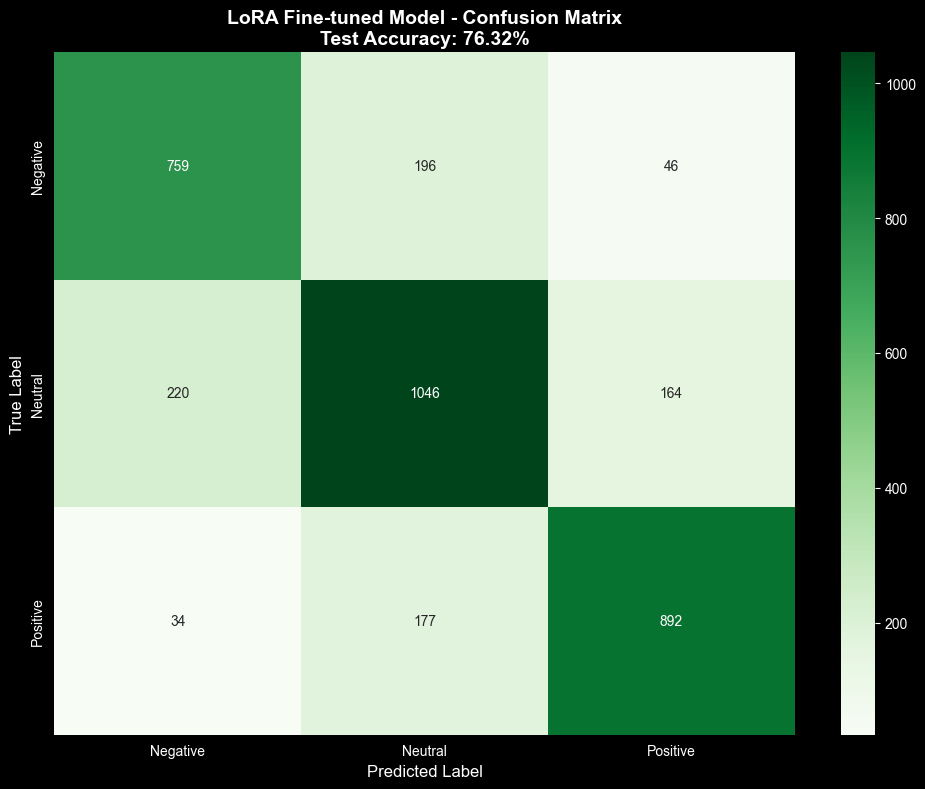


Classification Report:
              precision    recall  f1-score   support

    Negative     0.7493    0.7582    0.7537      1001
     Neutral     0.7371    0.7315    0.7343      1430
    Positive     0.8094    0.8087    0.8091      1103

    accuracy                         0.7632      3534
   macro avg     0.7653    0.7661    0.7657      3534
weighted avg     0.7631    0.7632    0.7631      3534


────────────────────────────────────────────────────────────────────────────────
6. Comparison: LoRA vs Other Methods
────────────────────────────────────────────────────────────────────────────────

Model                          Type                 Test Accuracy   Training Time  
LoRA Fine-tuned                Fine-tuned LLM               76.32%         861.97s
Linear SVM                     Classical ML                 64.91%          33.56s
Logistic Regression            Classical ML                 64.80%           4.62s
Linear (BERT)                  Neural Network               6

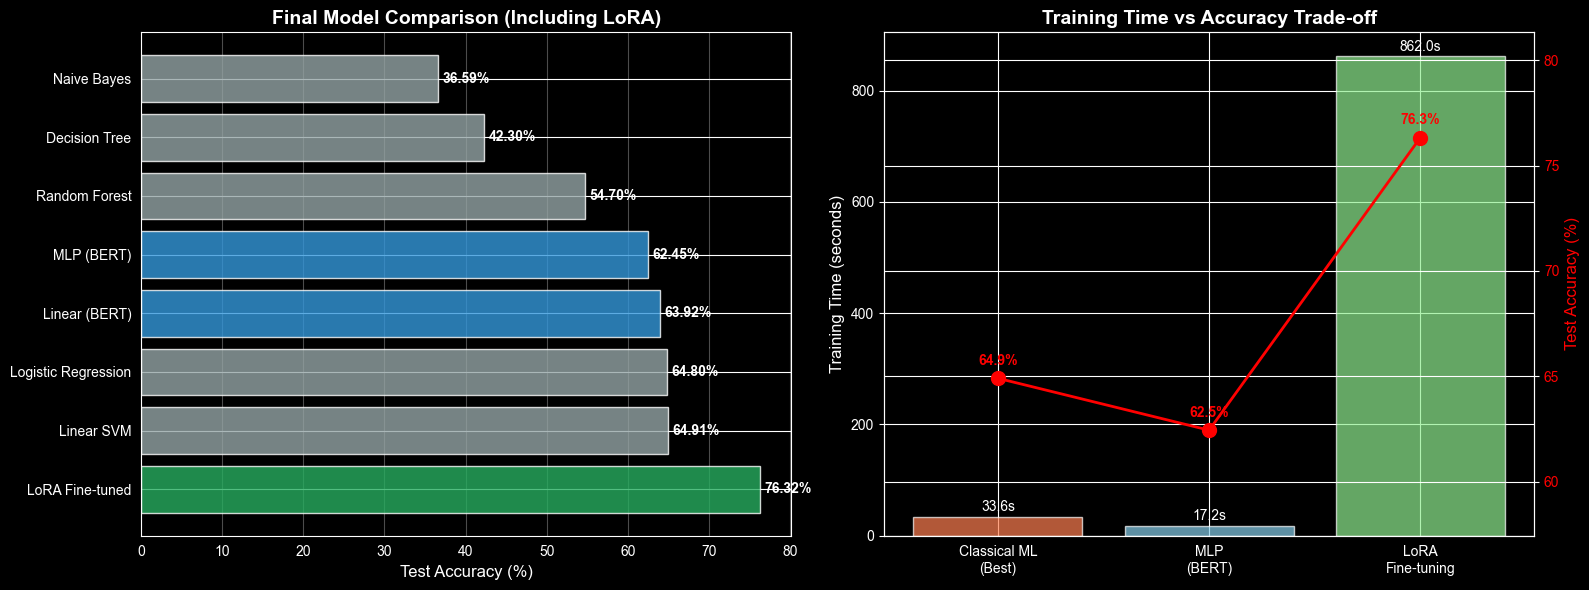

In [31]:
# Q7: Fine-tuning with LoRA (Low-Rank Adaptation)
print("="*80)
print("Q7: FINE-TUNING LLM WITH LoRA")
print("="*80)

# Check if PEFT library is available
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding


print("\n" + "─"*80)
print("1. Setting up LoRA configuration")
print("─"*80)

# LoRA configuration
# NOTE: For DistilBERT, the attention modules are named "q_lin" and "v_lin"
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,               # Sequence classification
    r=8,                                      # Rank of the update matrices (lower = fewer parameters)
    lora_alpha=16,                            # Scaling factor
    lora_dropout=0.1,                         # Dropout for regularization
    target_modules=["q_lin", "v_lin"],        # Which layers to adapt (DistilBERT specific)
    bias="none",
    inference_mode=False,
)

print(f"Task Type: {lora_config.task_type} (Sequence Classification)")
print(f"Low-Rank Matrix Rank (r): {lora_config.r}")
print(f"Scaling Factor (alpha): {lora_config.lora_alpha}")
print(f"Dropout Value: {lora_config.lora_dropout}")
print(f"Target Adaptation Layers: {lora_config.target_modules} (DistilBERT-specific)")
print(f"Bias Setting: {lora_config.bias}")
print(f"Inference Mode: {lora_config.inference_mode}")


print("\n" + "─"*80)
print("2. Loading base model and applying LoRA")
print("─"*80)

# Load model for sequence classification
model_name = "distilbert-base-uncased" # DistilBERT uses: 'q_lin', 'v_lin', 'k_lin', 'out_lin'"), BERT uses: 'query', 'value', 'key'"
print(f"Loading model: {model_name}")

lora_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_CLASSES,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
).to(device)

# Apply LoRA
lora_model = get_peft_model(lora_model, lora_config)

# Print trainable parameters
trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in lora_model.parameters())

print(f"\nModel Statistics:")
print(f"\tTotal parameters: {total_params:,}")
print(f"\tTrainable parameters: {trainable_params:,}")
print(f"\tPercentage trainable: {100 * trainable_params / total_params:.2f}%")
print(f"\nLoRA reduces trainable parameters by ~{100 * (1 - trainable_params / total_params):.1f}%!")

lora_model.print_trainable_parameters()

print("\n" + "─"*80)
print("3. Preparing dataset for Hugging Face Trainer")
print("─"*80)

# Create Hugging Face dataset
from datasets import Dataset

# Prepare data dictionaries
train_dict = {"text": train_x, "label": train_y}
val_dict = {"text": val_x, "label": val_y}
test_dict = {"text": test_x, "label": test_y}

# Create datasets
train_dataset_hf = Dataset.from_dict(train_dict)
val_dataset_hf = Dataset.from_dict(val_dict)
test_dataset_hf = Dataset.from_dict(test_dict)

print(f"\t - Training samples: {len(train_dataset_hf)}")
print(f"\t - Validation samples: {len(val_dataset_hf)}")
print(f"\t - Test samples: {len(test_dataset_hf)}")

# Tokenization function
tokenizer_lora = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer_lora(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

# Tokenize datasets
print("\nTokenizing datasets...")
train_dataset_hf = train_dataset_hf.map(tokenize_function, batched=True)
val_dataset_hf = val_dataset_hf.map(tokenize_function, batched=True)
test_dataset_hf = test_dataset_hf.map(tokenize_function, batched=True)

# Set format
train_dataset_hf.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset_hf.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset_hf.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("Datasets tokenized and ready")

print("\n" + "─"*80)
print("4. Training with LoRA")
print("─"*80)

# Training arguments
training_args = TrainingArguments(
    output_dir="./lora_sentiment_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,  # Higher LR for LoRA
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=50,
    warmup_steps=100,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
)

# Metric function
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

# Create Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset_hf,
    eval_dataset=val_dataset_hf,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer_lora),
)

print("\nStarting training...")
print("\t(This may take several minutes depending on your hardware)\n")

# Train
train_result = trainer.train()

print("\nTraining completed!")
print(f"\nTraining results:")
print(f"\t - Training loss: {train_result.training_loss:.4f}")
print(f"\t - Training time: {train_result.metrics['train_runtime']:.2f}s")

print("\n" + "─"*80)
print("5. Evaluation on test set")
print("─"*80)

# Evaluate
eval_results = trainer.evaluate(test_dataset_hf)

print(f"\nTest Results:")
print(f"\t - Accuracy: {eval_results['eval_accuracy']*100:.2f}%")
print(f"\t - F1 Score: {eval_results['eval_f1']:.4f}")
print(f"\t - Loss: {eval_results['eval_loss']:.4f}")

# Get predictions for confusion matrix
predictions = trainer.predict(test_dataset_hf)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_y

# Confusion matrix
plt.figure(figsize=(10, 8))
cm_lora = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm_lora, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'LoRA Fine-tuned Model - Confusion Matrix\nTest Accuracy: {eval_results["eval_accuracy"]*100:.2f}%',
            fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels,
                            target_names=['Negative', 'Neutral', 'Positive'],
                            digits=4))

print("\n" + "─"*80)
print("6. Comparison: LoRA vs Other Methods")
print("─"*80)

# Add LoRA results to comparison
all_results_final = all_results.copy()
all_results_final['LoRA Fine-tuned'] = {
    'test_accuracy': eval_results['eval_accuracy'] * 100,
    'train_time': train_result.metrics['train_runtime'],
    'type': 'Fine-tuned LLM'
}

# Print final comparison
print(f"\n{'Model':<30} {'Type':<20} {'Test Accuracy':<15} {'Training Time':<15}")
print("="*80)

sorted_final = sorted(all_results_final.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
for model_name, metrics in sorted_final:
    train_time_str = f"{metrics['train_time']:.2f}s" if isinstance(metrics['train_time'], float) else str(metrics['train_time'])
    print(f"{model_name:<30} {metrics['type']:<20} {metrics['test_accuracy']:>13.2f}% {train_time_str:>15}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ax1 = axes[0]
model_names_final = [name for name, _ in sorted_final[:8]]  # Top 8
accuracies_final = [metrics['test_accuracy'] for _, metrics in sorted_final[:8]]
colors_final = ['#27ae60' if 'LoRA' in name else '#3498db' if 'BERT' in name else '#95a5a6'
                for name in model_names_final]

bars = ax1.barh(model_names_final, accuracies_final, color=colors_final, alpha=0.8)
ax1.set_xlabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('Final Model Comparison (Including LoRA)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for bar, acc in zip(bars, accuracies_final):
    ax1.text(acc + 0.5, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%',
            va='center', fontsize=10, fontweight='bold')

# Training efficiency
ax2 = axes[1]
methods = ['Classical ML\n(Best)', 'MLP\n(BERT)', 'LoRA\nFine-tuning']
# Get representative times
classical_time = results_classical[sorted(results_classical.items(),
                                            key=lambda x: x[1]['test_accuracy'],
                                            reverse=True)[0][0]]['train_time']
times_compare = [classical_time, mlp_bert_train_time, train_result.metrics['train_runtime']]
accs_compare = [
    max(r['test_accuracy'] for r in results_classical.values()) * 100,
    test_acc_mlp.item(),
    eval_results['eval_accuracy'] * 100
]

bars2 = ax2.bar(methods, times_compare, color=['coral', 'skyblue', 'lightgreen'], alpha=0.7)
ax2.set_ylabel('Training Time (seconds)', fontsize=12)
ax2.set_title('Training Time vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax2_twin = ax2.twinx()
ax2_twin.plot(methods, accs_compare, 'ro-', linewidth=2, markersize=10, label='Accuracy')
ax2_twin.set_ylabel('Test Accuracy (%)', fontsize=12, color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.set_ylim([min(accs_compare)-5, max(accs_compare)+5])

for bar, time_val, acc in zip(bars2, times_compare, accs_compare):
    ax2.text(bar.get_x() + bar.get_width()/2, time_val + 5, f'{time_val:.1f}s',
            ha='center', va='bottom', fontsize=10)
    ax2_twin.text(bar.get_x() + bar.get_width()/2, acc + 0.5, f'{acc:.1f}%',
                    ha='center', va='bottom', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.show()
    
print("="*80)


## Rapport de la question Q7 : Fine-tuning d'un LLM avec LoRA

### Approche de résolution

La question Q7 est une question avancée optionnelle qui demande d'utiliser la technique LoRA (Low-Rank Adaptation) pour affiner (fine-tune) un grand modèle de langage pour la classification des sentiments. Les étapes principales incluent :

1.  **Comprendre le principe de LoRA** - Connaître cette technique de fine-tuning efficace en paramètres.
   
2.  **Configurer les paramètres LoRA** - Définir les hyperparamètres des matrices de rang faible.
   
3.  **Charger le modèle pré-entraîné et appliquer LoRA** - Geler les paramètres d'origine et ajouter des couches d'adaptation entraînables.
   
4.  **Entraînement et évaluation** - Utiliser le `Trainer` de Hugging Face pour l'entraînement.
   
5.  **Comparaison avec d'autres méthodes** - Vérifier l'efficacité de LoRA.
   
---

### Explication détaillée du principe de LoRA

LoRA : Adaptation à rang bas des grands modèles de langage, une technique de réglage fin efficace qui :

- N’entraîne qu’un petit nombre de paramètres (0,1 à 1 % du modèle initial)
  
- Conserve le modèle initial dans un état figé
  
- Ajoute des couches adaptatrices entraînables (« adapter layers »)
  
- Est beaucoup plus rapide et moins gourmande en mémoire que le réglage fin complet
  
- Permet de passer facilement d’une tâche à l’autre

#### Principe mathématique

Le fine-tuning traditionnel met à jour tous les poids :
$$W' = W + \Delta W$$

LoRA utilise une décomposition de rang faible :
$$W' = W + BA$$

Où :
- $W \in \mathbb{R}^{d \times k}$ - Poids d'origine (gelés)

- $B \in \mathbb{R}^{d \times r}$ - Matrice LoRA A

- $A \in \mathbb{R}^{r \times k}$ - Matrice LoRA B

- $r \ll \min(d, k)$ - Rang faible

**Calcul du nombre de paramètres** :

- Original : $d \times k$ paramètres

- LoRA : $(d + k) \times r$ paramètres

- Quand $r=8$, $d=k=768$, les paramètres sont réduits d'environ $\frac{768 \times 768}{(768+768) \times 8} \approx 48$ fois.

#### Schéma de l'architecture

Propagation avant originale :

<p align="center">
x -> W -> y
</p>


Propagation avant LoRA (Adaptation de rang faible):
<p align="center">
 x -> W -> y <br>
 ⬇&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;⬆ <br>
 B ------> A
</p>


---

### Comparaison avec d'autres méthodes

| Méthode | Paramètres entraînables | Temps d'entraînement | Utilisation mémoire | Précision |
|------|-----------|----------|----------|--------|
| ML traditionnel | Peu | Rapide | Faible | Moyenne |
| MLP (BERT) | ~100K | Moyen | Moyenne | Assez élevée |
| Fine-tuning complet | ~67M | Lent | Élevée | Élevée |
| **Fine-tuning LoRA** | **~300K** | **Assez rapide** | **Assez faible** | **Élevée** |

---

### Avantages de LoRA et scénarios d'application

#### Avantages

1.  **Efficacité des paramètres** : Entraîne seulement 0,5% des paramètres pour obtenir des résultats proches du fine-tuning complet.
   
2.  **Économe en mémoire** : Pas besoin de stocker les gradients complets, l'utilisation de la mémoire GPU est considérablement réduite.
   
3.  **Flexibilité de changement de tâche** : Possibilité de sauvegarder plusieurs adaptateurs LoRA partageant le même modèle de base.
   
4.  **Déploiement facile** : Les poids LoRA peuvent être fusionnés dans le modèle de base.

#### Scénarios d'application

- Ressources de calcul limitées (comme une seule carte GPU grand public).

- Nécessité d'affiner pour plusieurs tâches.

- Souhait de conserver les poids du modèle original.

- Adaptation rapide à un nouveau domaine.